In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 3.3 MB/s eta 0:00:00


In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import RegexpTokenizer





In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
from sklearn import set_config
set_config(display='diagram')


In [5]:
data_news = pd.read_csv('cleaned_news.csv')

In [6]:
data_news.shape, data_news.isna().sum()

((38638, 9),
 title                      0
 text                       0
 subject                    0
 label                      0
 text_length                0
 title_length               0
 exclamations_mark_count    0
 questions_mark_count       0
 uppercase_words_count      0
 dtype: int64)

In [7]:
# creating a custom transformer
from sklearn.base  import BaseEstimator, TransformerMixin


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = stopwords.words('english')
        self.freqwords = set([
            'trump', 'president', 'reuters', 'state', 'donald',
            'states', 'house', 'government', 'republican', 'united'
        ])
        self.stopwords_set = set(self.stop_words).union(self.freqwords)
        self.lemmatizer = WordNetLemmatizer()
        # Tokenize
        self.tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

    def preprocess_text(self, text):
        # Lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)

        # Remove standalone numbers
        text = re.sub(r'\b\d+\b', '', text)

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove punctuation
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)

        # Remove newlines and unicode punctuation
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'[’“”…]', '', text)

        # Remove emojis
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub('', text)

        # Expand contractions
        contractions = {
            "isn't": "is not", "he's": "he is", "wasn't": "was not", "there's": "there is",
            "couldn't": "could not", "won't": "will not", "they're": "they are", "she's": "she is",
            "wouldn't": "would not", "haven't": "have not", "that's": "that is", "you've": "you have",
            "what's": "what is", "weren't": "were not", "we're": "we are", "hasn't": "has not",
            "you'd": "you would", "shouldn't": "should not", "let's": "let us", "they've": "they have",
            "you'll": "you will", "i'm": "i am", "we've": "we have", "it's": "it is", "don't": "do not",
            "that´s": "that is", "i´m": "i am", "it’s": "it is", "she´s": "she is", "i’m": "i am",
            "i’d": "i did", "there’s": "there is"
        }

        for contraction, expanded in contractions.items():
            text = re.sub(rf"\b{re.escape(contraction)}\b", expanded, text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()


        tokens = self.tokenizer.tokenize(text)


        # Remove stopwords
        tokens = [word for word in tokens if word not in self.stopwords_set]

        # Lemmatize
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        # Return processed string
        return ' '.join(tokens)


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess_text(text) for text in X]


## TextPreprocessor

In [8]:
nltk.download('punkt')  # Do this once
data_news['text_cleaned'] = TextPreprocessor().fit_transform(data_news['text'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Evaluating the performance of the navie model first

In [ ]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
def train_and_evaluate_model(X,y,model=MultinomialNB(), model_name='MultinominalNB', vecotrizer='CountVectorizer'):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=42)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    f1score = f1_score(predicted, y_test)
    print(f'{model_name} model accuracy is {f1score*100 : 04.2f}% using {vecotrizer}')
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, predicted))
    return model, predicted, f1score, X_test, y_test


In [ ]:
# vecotrization

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')


tfid = CountVectorizer(
    stop_words=None,
    ngram_range=(1,1),
    tokenizer=token.tokenize,
    token_pattern=None
)

text_counts_1_2 = tfid.fit_transform(data_news['text_cleaned'])


In [ ]:
_, _, _ , _, _ = train_and_evaluate_model(text_counts_1_2, data_news['label'])

MultinominalNB model accuracy is  94.96% using CountVectorizer
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4238
           1       0.96      0.94      0.95      3490

    accuracy                           0.95      7728
   macro avg       0.96      0.95      0.95      7728
weighted avg       0.96      0.95      0.95      7728



## Conclusion
> Built a baseline Multinomial Naive Bayes model using CountVectorizer, achieving 95% F1-score.

> Let's build a more robust model by using metadata egineered features + ensemble learning + hyperparameter tunning

## Creating a pipline for optimizing vetorizer and classifier parameters

In [ ]:
data_news.head()

,title,text,subject,label,text_length,title_length,exclamations_mark_count,questions_mark_count,uppercase_words_count,text_cleaned
0,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,politics,1,1245,130,0,0,4,gay mafia new corporate article need read shee...
1,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,1,3157,117,0,5,14,anyone really think hillary clinton come clean...
2,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,politics,1,1994,76,0,1,0,irony lost u hillary compared wanted take nixo...
3,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",left-news,1,658,80,0,1,4,case missed sen harry reid rnv announced last ...
4,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,1,2488,49,0,4,5,nothing like political cronyism make stomach c...


In [9]:
# final_df = news_df.merge(new_text_df, left_index=True, right_index=True)

final_df = data_news.drop(columns=['title', 'text', 'title_length'])

# final_df.rename(columns={'no_sw_lem': 'text_cleaned'}, inplace=True)
# final_df.head()

final_df.rename(columns={'text_cleaned': 'text'}, inplace=True)

X = final_df.drop(columns=['label' ,'subject'])
y = final_df.label



X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=42
                                                    )

In [ ]:

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38638 entries, 0 to 38637
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   text_length              38638 non-null  int64 
 1   exclamations_mark_count  38638 non-null  int64 
 2   questions_mark_count     38638 non-null  int64 
 3   uppercase_words_count    38638 non-null  int64 
 4   text                     38638 non-null  object
dtypes: int64(4), object(1)
memory usage: 1.5+ MB


In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30910, 5), (7728, 5), (30910,), (7728,))

In [13]:
y_train.value_counts()

,count
label,
0,16953
1,13957


In [ ]:
X_train.dropna(inplace=True, how='any')
X_test.dropna(inplace=True, how='any')
y_train.dropna(inplace=True, how='any')
y_test.dropna(inplace=True, how='any')

## PipeLine to merge text_data and metadata features together

In [14]:

trf1 = ColumnTransformer(
    transformers=[
        ('vectorizer', CountVectorizer(), 'text')
    ],
    remainder='passthrough',  # keeps metadata columns

    force_int_remainder_cols=False # treat remainder columns by name, not index.
)

model_pipe = Pipeline(
    steps=[
        ('trf1', trf1),
        ('classifier', XGBClassifier(objective='binary:logistic', eval_metric='logloss'))
    ]
)



model_pipe  # Displays a diagram of the pipeline

Pipeline(steps=[('trf1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  CountVectorizer(),
                                                  'text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  CountVectorizer(),
                                                  'text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
from sklearn.metrics import f1_score, classification_report
y_pred = model_pipe.predict(X_test)

f1score= f1_score(y_test, y_pred)*100

print(f"Accracy of the model is {f1score:.4f}%")
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accracy of the model is 98.4607%
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4238
           1       0.99      0.98      0.98      3490

    accuracy                           0.99      7728
   macro avg       0.99      0.99      0.99      7728
weighted avg       0.99      0.99      0.99      7728



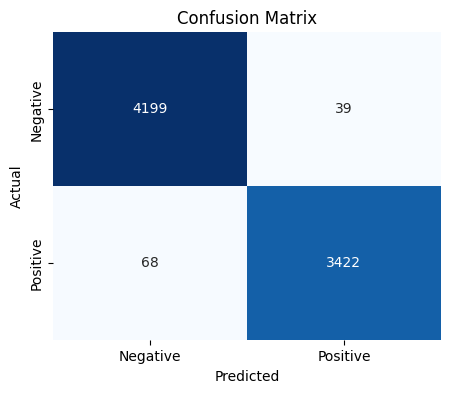

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")


Precision: 0.9887315804680729
Recall: 0.9805157593123209


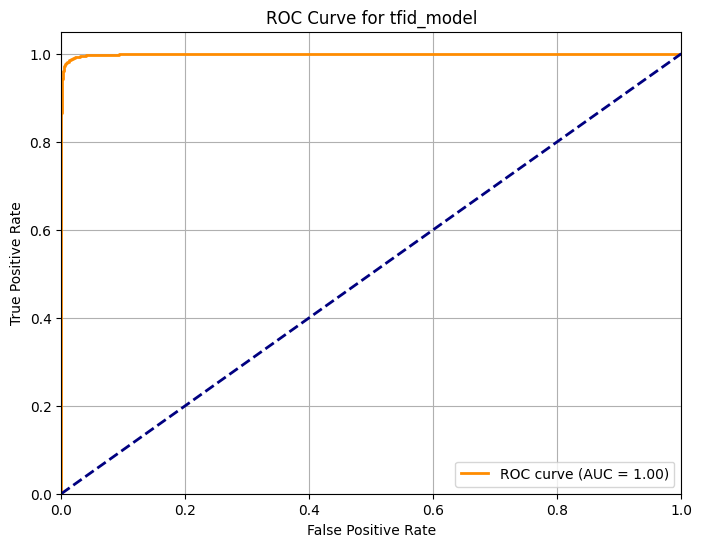

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Get predicted probabilities for the positive class
y_probs = model_pipe.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for tfid_model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Let's use TFid vectorizer

In [ ]:
# Transformer using TfidfVectorizer
trf_tfid = ColumnTransformer(
    transformers=[
        ('vectorizer', TfidfVectorizer(), 'text')
    ],
    remainder='passthrough',  # Keep non-text features
    force_int_remainder_cols=False
)

# New pipeline using Tfidf
tfid_model = Pipeline(
    steps=[
        ('trf1', trf_tfid),
        ('classifier', XGBClassifier(objective='binary:logistic', eval_metric='logloss'))
    ]
)

In [ ]:
tfid_model.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  TfidfVectorizer(),
                                                  'text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
from sklearn.metrics import f1_score, classification_report
y_pred_tfid = tfid_model.predict(X_test)

f1score= f1_score(y_test, y_pred_tfid)*100

print(f"Accracy of the model is {f1score:.4f}%")
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred_tfid))

Accracy of the model is 98.2582%
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4238
           1       0.99      0.98      0.98      3490

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



## Just after using the countvectorizer with meta data  features our model has accuracy up 98.56%. Let's use hpyerparameter for building a more robust model

## Tuning our model

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


param_dist = {
    'trf1__vectorizer__ngram_range': [(1, 1), (1, 2)],
    'trf1__vectorizer__max_features': randint(3000, 10000),

    # XGBoost parameters
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__n_estimators': randint(200, 500),
    'classifier__max_depth': randint(3, 10),
    'classifier__subsample': uniform(0.7, 0.3),
    'classifier__colsample_bytree': uniform(0.7, 0.3),
    'classifier__scale_pos_weight': [1.0, 1.2, 1.5, 2, 5]  # weight fake class
}


from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    model_pipe,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)


In [16]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('trf1',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('vectorizer',
                                                                               CountVectorizer(),
                                                                               'text')])),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_by...
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7befe4a70710>,
                                        'classifier__scale_pos_weight': [1.0,
                                                                         1.2,
                                                                         1.5, 2,
                                                                         5],
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7befe465c690>,
                                        'trf1__vectorizer__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7befe4c060d0>,
                                        'trf1__vectorizer__ngram_range': [(1,
                                                                           1),
                                                                          (1,
                                                                           2)]},
                   random_state=42, scoring='f1', verbose=2)

In [17]:
best_params = random_search.best_params_
from pprint import pprint
pprint(best_params)

# saving these parameters
import pickle
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

# {'classifier__learning_rate': np.float64(0.24555278841790407),
#  'classifier__max_depth': 5,
#  'classifier__n_estimators': 463,
#  'trf1__vectorizer__max_features': 5638,
#  'trf1__vectorizer__ngram_range': (1, 2)}

# updated params
# {'classifier__colsample_bytree': np.float64(0.8148780624261369),
#  'classifier__learning_rate': np.float64(0.20434241907782077),
#  'classifier__max_depth': 5,
#  'classifier__n_estimators': 456,
#  'classifier__scale_pos_weight': 5,
#  'classifier__subsample': np.float64(0.8683831592708489),
#  'trf1__vectorizer__max_features': 9910,
#  'trf1__vectorizer__ngram_range': (1, 2)}

{'classifier__colsample_bytree': np.float64(0.8148780624261369),
 'classifier__learning_rate': np.float64(0.20434241907782077),
 'classifier__max_depth': 5,
 'classifier__n_estimators': 456,
 'classifier__scale_pos_weight': 5,
 'classifier__subsample': np.float64(0.8683831592708489),
 'trf1__vectorizer__max_features': 9910,
 'trf1__vectorizer__ngram_range': (1, 2)}


In [18]:
best_model_pipeline = random_search.best_estimator_

In [19]:
best_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  CountVectorizer(max_features=9910,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=np.float64(0.81487806242613...
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.20434241907782077),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=456, n_jobs=None,
                               num_parallel_tree=None, ...))])

## Evaluating our model

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(model_pipe, X_train, y_train, cv=cv_strategy)


In [35]:
# Optionally, print the mean and standard deviation
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.98479456 0.98576512 0.98673568 0.9862504  0.98495632]
Mean accuracy: 0.9857004205758655
Standard deviation: 0.0007419828496395617


In [70]:
from sklearn.metrics import f1_score, classification_report
y_pred = best_model_pipeline.predict(X_test)

f1score= f1_score(y_test, y_pred)*100

In [71]:
print(f"Accracy of the model is {f1score:.4f}%")
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Real News', 'Fake News'], digits=4))

Accracy of the model is 98.7973%
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   Real News     0.9906    0.9896    0.9901      4238
   Fake News     0.9874    0.9885    0.9880      3490

    accuracy                         0.9891      7728
   macro avg     0.9890    0.9891    0.9890      7728
weighted avg     0.9891    0.9891    0.9891      7728



In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)



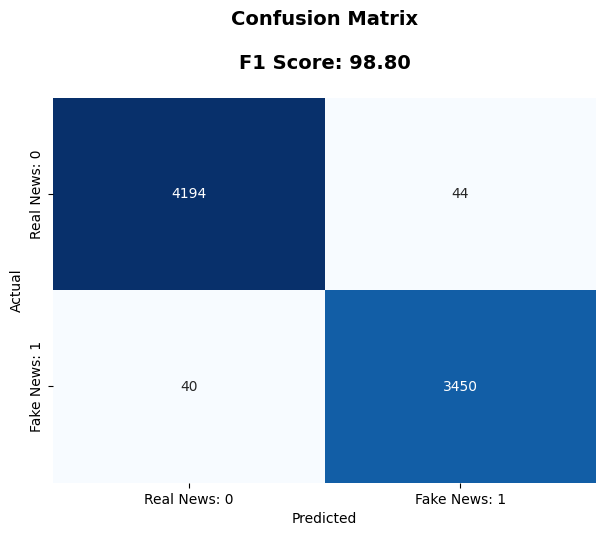

In [73]:
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Real News: 0', 'Fake News: 1'],
            yticklabels=['Real News: 0', 'Fake News: 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\n\nF1 Score: {f1score:.2f}\n', fontsize=14, fontweight='bold', pad=5)


plt.savefig('confusion_matrix.png')
plt.show()

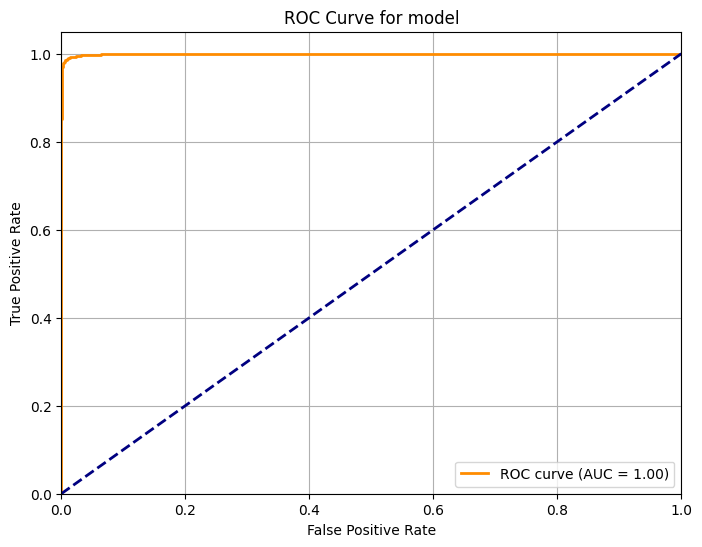

In [56]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Get predicted probabilities for the positive class
y_probs = best_model_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

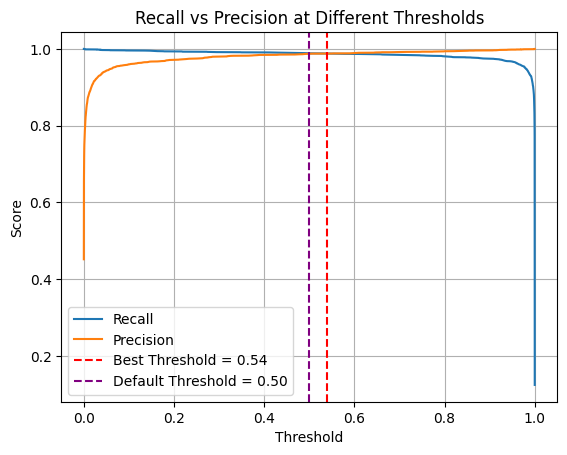

In [43]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Compute index where precision and recall are closest
diff = np.abs(precision[:-1] - recall[:-1])  # Exclude last precision/recall element
min_index = np.argmin(diff)
best_threshold = thresholds[min_index]

# Plot precision and recall
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, precision[:-1], label='Precision')

# Add vertical line at the best threshold
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.axvline(x=0.5, color='purple', linestyle='--', label=f'Default Threshold = {0.5:.2f}')


# Labels and formatting
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall vs Precision at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

           0     0.9899    0.9901    0.9900      4238
           1     0.9880    0.9877    0.9878      3490

    accuracy                         0.9890      7728
   macro avg     0.9889    0.9889    0.9889      7728
weighted avg     0.9890    0.9890    0.9890      7728
 


F1 Score: 98.782060


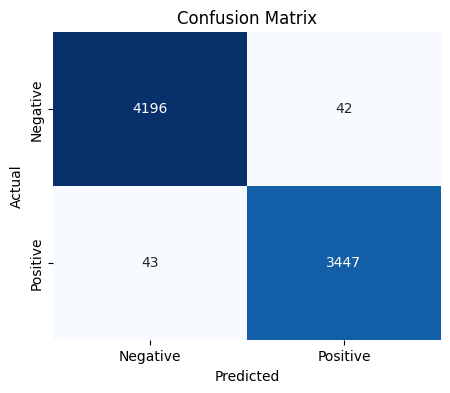

In [44]:
y_probs = best_model_pipeline.predict_proba(X_test)[:, 1]

# Try a lower threshold to increase recall
threshold = 0.54
y_pred = (y_probs >= threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix



print(classification_report(y_test, y_pred, digits=4), '\n\n')
print(f"F1 Score: {f1_score(y_test, y_pred)*100:2f}")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()



---

The **first model** improves slightly:

* **Accuracy** = 0.9891
* **F1-score (Real News)** = 0.9901, **(Fake News)** = 0.9880
* **Macro F1** = 0.9890

The **second model** achieves:

* **Accuracy** = 0.9890
* **F1-score (Class 0)** = 0.9900, **(Class 1)** = 0.9878
* **Macro F1** = 0.9889



**Conclusion**: The first model consistently edges out the second model by small but measurable margins, making it the better choice.

---

## Conclusion
After combining meta data features created using feature engineering, and fine tunning our xbgoost model using randomsearch cv 99% accuracy is achieved.

In [30]:
# saving model

import joblib

joblib.dump(best_model_pipeline, 'model_pipeline.pkl')

['model_pipeline.pkl']

In [ ]:
model_pipe = joblib.load('model_pipeline.pkl')

In [ ]:
print(best_model_pipeline)

Pipeline(steps=[('trf1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  CountVectorizer(max_features=5638,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stop...
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=Non

In [ ]:
print(model_pipe.get_params)

<bound method Pipeline.get_params of Pipeline(steps=[('trf1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  CountVectorizer(max_features=5638,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stop...
                               gamma=None, grow_policy=None,
                               importance_type=None,
                     